In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D,AveragePooling2D, concatenate,Input

from math import e
from sklearn.model_selection import train_test_split
from keras.models import Model

In [3]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
y=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2014-12-31'))
y=y/25.0
#y

In [4]:
z500Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/StdAnomERA5NH_500_z_daily_NovDecJan.nc')

In [5]:
z=z500Data.z.shift(time=1)

In [6]:
zTs=z[((z.time.dt.month>11) | (z.time.dt.month<2)) & (z.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(90,0),longitude=slice(0,120))

In [7]:
z_train, z_test, y_train,y_test = train_test_split( zTs, y,test_size=0.20, random_state=0)

In [8]:
ztrain=z_train.values
ztrain=ztrain[:,:,:,None]
ztrain.shape
ytrain=y_train.values
ytrain=ytrain[:,None]
ytrain.shape
ztest=z_test.values
ztest=ztest[:,:,:,None]
ztest.shape
ytest=y_test.values
ytest=ytest[:,None]
ytest.shape

(434, 1)

Epoch 1/9
55/55 [==============================] - 3s 43ms/step - loss: 0.2194 - val_loss: 0.1693
Epoch 2/9
55/55 [==============================] - 3s 48ms/step - loss: 0.1632 - val_loss: 0.1657
Epoch 3/9
55/55 [==============================] - 2s 28ms/step - loss: 0.1662 - val_loss: 0.1651
Epoch 4/9
55/55 [==============================] - 2s 33ms/step - loss: 0.1653 - val_loss: 0.1695
Epoch 5/9
55/55 [==============================] - 2s 33ms/step - loss: 0.1651 - val_loss: 0.1667
Epoch 6/9
55/55 [==============================] - 2s 30ms/step - loss: 0.1552 - val_loss: 0.1626
Epoch 7/9
55/55 [==============================] - 2s 31ms/step - loss: 0.1548 - val_loss: 0.1670
Epoch 8/9
55/55 [==============================] - 2s 37ms/step - loss: 0.1543 - val_loss: 0.1660
Epoch 9/9
55/55 [==============================] - 2s 38ms/step - loss: 0.1489 - val_loss: 0.1653


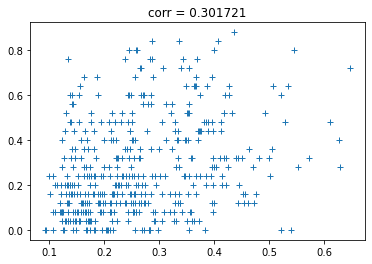

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D,AveragePooling2D

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(7 ,7), activation='relu', input_shape=(ztrain.shape[1],ztrain.shape[2],1)))
model.add(MaxPooling2D())

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=256, kernel_size=(1,1), activation='relu'))
#model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
#model.add(Conv2D(filters=3, kernel_size=(1, 1), activation='relu'))
#model.add(AveragePooling2D())

model.add(Flatten())

model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=60, activation='relu'))
model.add(Dense(units=40, activation='relu'))
#model.add(Dense(units=20, activation='relu'))

model.add(Dense(units=1, activation = 'linear'))
model.compile(optimizer='adam', loss='mae')

history = model.fit(ztrain, ytrain, validation_data=(ztest, ytest), epochs=9)
yy_test = model.predict(ztest)

test_corr = np.corrcoef(yy_test[:,0],y_test)[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,ytest,'+')
#y_test